In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.ops
import torch_optimizer as optim

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

import time
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
exe_file = "/mnt/ssd1/nyh/AI_Competition"

In [2]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# train_img_shape = (1024, 1024)
train_img_shape = (256, 256)
train_resize_img_shape = (224, 224)
valid_img_shape = (224, 224)
test_img_shape = (224, 224)
batch_size = 64
threshold = 0.6
random_seed = 20230705
loss_func = [["DICE",0.8], ["FOCAL",0.2]] # first = DICE, second = FOCAL
model = smp.UnetPlusPlus

model_name = ["se_resnext101_32x4d","imagenet"]
optimizer_name = "RAdam"

In [4]:
def random_seed_func(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

In [5]:
cpu_core_num = os.cpu_count()
gpu_num = torch.cuda.device_count()

print(f"{cpu_core_num} cpu cores")
print("Let's use", torch.cuda.device_count(), "GPUs!")

36 cpu cores
Let's use 4 GPUs!


## Utils
- https://dacon.io/competitions/official/236092/talkboard/408732?page=1&dtype=recent


In [7]:
def dice_score(prediction: np.array, ground_truth: np.array, smooth=1e-7):
    '''
    Calculate Dice Score between two binary masks.
    '''
    scores = []
    for i in range(prediction.shape[0]):
        intersection = np.sum(prediction[i] * ground_truth[i])
        score = (2.0 * intersection + smooth) / (np.sum(prediction[i]) + np.sum(ground_truth[i]) + smooth)

        scores.append(score)

    scores = sum(scores)/prediction.shape[0]
    return scores


def calculate_dice_scores(ground_truth_df, prediction_df, img_shape=(224, 224)):
    print(ground_truth_df.shape, prediction_df.shape)

    # Find the indices where the prediction ids exist in the ground truth ids
    prediction_ids = prediction_df.tolist()
    ground_truth_ids = ground_truth_df.tolist()
    matching_indices = [i for i in range(len(prediction_ids)) if prediction_ids[i] in ground_truth_ids]

    # Filter the prediction and ground truth dataframes based on the matching indices
    prediction_df = prediction_df[matching_indices]
    ground_truth_df = ground_truth_df[matching_indices]

    # # Extract the mask_rle columns
    print(ground_truth_df.shape, prediction_df.shape)
    pred_mask_rle = prediction_df
    gt_mask_rle = ground_truth_df
    # pred_mask_rle = prediction_df[:, 0, :, :].squeeze(0)
    # gt_mask_rle = ground_truth_df.squeeze(0)

    def calculate_dice(pred_rle, gt_rle):
        pred_mask = rle_decode(pred_rle, img_shape)
        gt_mask = rle_decode(gt_rle, img_shape)

        if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:
            return dice_score(pred_mask, gt_mask)
        else:
            return None  # No valid masks found, return None

    dice_scores = []
    for pred_rle, gt_rle in zip(pred_mask_rle, gt_mask_rle):
        dice_score = calculate_dice(pred_rle, gt_rle)
        # print(dice_score)
        if dice_score is not None:
            dice_scores.append(dice_score)

    return np.mean(dice_scores)

In [8]:
# RLE 디코딩 함수

def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [9]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, mode = None, transform=None, infer=False):
        
        self.data = pd.read_csv(csv_file)
        self.mode = mode # index number // Train_test_split
        self.transform = transform
        self.infer = infer

        if mode is not None:
            self.data = self.data.loc[self.mode]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
    
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = cv2.imread(mask_rle)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

## Data Loader

In [10]:
train_transform = A.Compose(
    [   
        A.Resize(train_img_shape[0], train_img_shape[1]),
        A.RandomCrop(train_resize_img_shape[0], train_resize_img_shape[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p = 0.5),
        ToTensorV2()
    ]

)

vaild_transform = A.Compose(
    [   
        A.Resize(valid_img_shape[0], valid_img_shape[1]),
        ToTensorV2()
    ]
)

test_transform = A.Compose(
    [   
        A.Resize(test_img_shape[0], test_img_shape[1]),
        ToTensorV2()
    ]
)

In [11]:
img_path = "/mnt/ssd1/nyh/AI_Competition/train_csv.csv"
len_data = len(pd.read_csv(img_path))
dataset_list = [i for i in range(len_data)]
random.shuffle(dataset_list)
train_dataset_list = dataset_list[:int(len_data*0.9)]
valid_dataset_list = dataset_list[int(len_data*0.9):]

train_dataset = SatelliteDataset(csv_file=img_path , mode = train_dataset_list, transform=train_transform)
valid_dataset = SatelliteDataset(csv_file=img_path, mode = valid_dataset_list, transform=vaild_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [ ]:
train_dataloader.__len__(), valid_dataloader.__len__()

In [16]:
model = smp.UnetPlusPlus
model = model(classes=2,
                encoder_name=model_name[0],
                encoder_weights=model_name[1]
               ).to(device) # DeepLabV3Plus -> UnetPlutPlus

In [ ]:
model.load_state_dict(torch.load("./best_se_resnext101_32x4d_val_87.14_(81.8).pt")['model_state_dict'])

In [18]:
# Sub Boundary network.

model2 = smp.UnetPlusPlus
model2 = model2(classes=2,
                in_channels = 4,
                encoder_name="se_resnext50_32x4d",
                encoder_weights=model_name[1]
               ).to(device) # DeepLabV3Plus -> UnetPlutPlus

## Model Train

In [20]:
#PyTorch
ALPHA = 0.5
BETA = 0.5

class TverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA):
        
        inputs = F.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky

In [21]:
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

class FocalTverskyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalTverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=ALPHA, beta=BETA, gamma=GAMMA):
        
        inputs = F.sigmoid(inputs)       
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        TP = (inputs * targets).sum()    
        FP = ((1-targets) * inputs).sum()
        FN = (targets * (1-inputs)).sum()
        
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = (1 - Tversky)**gamma
                       
        return FocalTversky

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=[0.25, 0.75], size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = torch.tensor(alpha)
        self.size_average = size_average

    def forward(self, inputs, targets):
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha[1] * (1 - pt) ** self.gamma * BCE_loss
        if self.size_average:
            return F_loss.mean()
        else:
            return F_loss.sum()


In [23]:
if torch.cuda.device_count() > 1:
  print("Let's use", torch.cuda.device_count(), "GPUs!")
  model = nn.DataParallel(model).to(device)

def criterion(pred, ground_truth, loss_func):
    bce_loss = torch.nn.BCEWithLogitsLoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')
    tversky_loss = TverskyLoss()
    focal_loss = FocalLoss()
    
    bce_values = bce_loss(pred, ground_truth)
    dice_value = dice_loss(pred, ground_truth)
    tversky_value = tversky_loss(pred, ground_truth)
    focal_values = focal_loss(pred, ground_truth)
    
    if loss_func[0][0] == "DICE": loss_value_1 = dice_value * loss_func[0][1]
    elif loss_func[0][0] == "BCE": loss_value_1 = bce_values * loss_func[0][1] #BCE
    elif loss_func[0][0] == "TVERSKY": loss_value_1 = tversky_value * loss_func[0][1] #tversky

    if loss_func[1][0] == "FOCAL": loss_value_2 = focal_values * loss_func[1][1]

    return loss_value_1 + loss_value_2

if optimizer_name == "RAdam": optimizer = optim.RAdam(model.parameters(), lr=0.001)
elif optimizer_name == "adam": optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer = optimizer, T_max=5) #learning_Rate를 조절하는 스케줄려를 설정, T_max는 반주기의 크기

Let's use 4 GPUs!


In [26]:
epochs = 100
stop_iter = 15
img_crop =  64

optimizer = optim.RAdam(model2.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer = optimizer, T_max=10)

for epoch in range(epochs):

    train_total_loss = 0.0
    train_total_count = 0
    train_total_count2 = 0.0
    train_total_count3 = 0.0
    train_total_data = 0

    big_dice_score = 0.0
    small_dice_score = 0.0
    crop_dice_score = 0.0

    val_total_loss = 0.0
    val_total_count = 0
    val_total_data = 0
    
    start_time = time.time()
    model.eval()
    model2.train()
    
    with tqdm(train_dataloader,desc='Train',unit='batch') as tepoch:
        for index, (images, masks) in enumerate(tepoch):

            images, masks = images.float().to(device), masks.float().to(device)
            
            outputs = model(images).mean(axis = 1)
            outputs_mask = torch.sigmoid(outputs).cpu().detach().numpy()
            outputs_mask = (outputs_mask > threshold).astype(np.uint8)
            dice = dice_score(outputs_mask, masks.cpu().detach().numpy())

            crop_32_input, crop_32_gt, crop_32_gt_info = [], [], []
            for i, img in enumerate(outputs_mask):
                # indices = torch.where(torch.Tensor(img) == 1) # [Row, Col]
                dst = cv2.dilate(img, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))) # 모폴로지 팽창 연산
                diff_clamped = torch.clamp(torch.Tensor(dst)- torch.Tensor(img), min=0, max=1) # 팽창 - 원본 => 경계
                indices = torch.where(diff_clamped == 1) # [Row, Col]
                xx, yy = torch.clamp(indices[0] - img_crop//2, min=0, max=224-img_crop), torch.clamp(indices[1] - img_crop//2, min=0, max=224-img_crop)

                if xx.shape == torch.Tensor([]).shape: continue
                boundary_mask = [torch.stack([x, y, x+img_crop, y+img_crop]) for x, y in zip(xx, yy)]
                boundary_mask = torch.stack(boundary_mask)
                boundary_mask_output = torchvision.ops.nms(boundary_mask[:, :4].float(), torch.ones(boundary_mask.shape[0]), 0.3)

                # bn_idx = boundary_mask[boundary_mask_output]
                for x, y, _, _ in  boundary_mask[boundary_mask_output]:
                    crop_32_input.append(torch.cat([images[i, :, x:x+img_crop, y:y+img_crop], torch.Tensor(outputs_mask[i, x:x+img_crop, y:y+img_crop].reshape(1, img_crop, img_crop)).to(device)], axis = 0)) # 입력 이미지 차원 [(B+num), 4, 32, 32]
                    crop_32_gt.append(masks[i, x:x+img_crop, y:y+img_crop]) # 정답 차원 [(B+num), 32,32]
                    crop_32_gt_info.append([i,x,y])
                
            if crop_32_input.__len__() == 0: continue
            crop_32_input = torch.stack(crop_32_input)
            crop_32_gt = torch.stack(crop_32_gt)

            crop_32_input, crop_32_gt = crop_32_input.to(device), crop_32_gt.to(device)
            
            optimizer.zero_grad()
            pred = model2(crop_32_input).mean(1)
            pred_32_mask = torch.sigmoid(pred).cpu().detach().numpy()
            pred_32_mask = (pred_32_mask > threshold).astype(np.uint8)

            for (batch_num_idx, idx_x, idx_y), pred_32_mask_one in zip(crop_32_gt_info, pred_32_mask):
                outputs_mask[batch_num_idx, idx_x:idx_x+img_crop, idx_y:idx_y+img_crop] = pred_32_mask_one

            dice2 = dice_score(outputs_mask, masks.cpu().detach().numpy())        
            dice3 = dice_score(pred_32_mask, crop_32_gt.cpu().detach().numpy())        
            loss = criterion(pred, crop_32_gt, loss_func)

            loss.backward()
            optimizer.step()

            train_total_count += dice
            train_total_count2 += dice2
            train_total_count3 += dice3
            train_total_loss += loss.item()
            tepoch.set_postfix(loss=train_total_loss/(index+1), dice = train_total_count/(index+1), dice2 = train_total_count2/(index+1), dice3 = train_total_count3/(index+1))
            
    train_total_loss /= index
    train_accuracy = train_total_count / index * 100
    print(f"Train Loss: {train_total_loss:.4f}\t\tTrain acc: {train_accuracy} Train_acc2 {train_total_count2/index * 100}")

    start_time = time.time()
    model2.eval()
    val_total_count2 = 0.0
    val_total_count3 = 0.0
    with tqdm(valid_dataloader,desc='Validation',unit='batch') as tepoch:
        for index, (images, masks) in enumerate(tepoch):
            images = images.float().to(device)
            masks = masks.float().to(device)

            with torch.no_grad():

                outputs = model(images).mean(axis = 1)
                outputs_mask = torch.sigmoid(outputs).cpu().detach().numpy()
                outputs_mask = (outputs_mask > threshold).astype(np.uint8) # Threshold = 0.35
                dice = dice_score(outputs_mask, masks.cpu().detach().numpy())

                crop_32_input, crop_32_gt, crop_32_gt_info = [], [], []
                for i, img in enumerate(outputs_mask):
                    dst = cv2.dilate(img, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))) # 모폴로지 팽창 연산
                    diff_clamped = torch.clamp(torch.Tensor(dst)- torch.Tensor(img), min=0, max=1) # 팽창 - 원본 => 경계
                    indices = torch.where(diff_clamped == 1) # [Row, Col]
                    # indices = torch.where(torch.Tensor(img) == 1) # [Row, Col]
                    xx, yy = torch.clamp(indices[0] - img_crop//2, min=0, max=224-img_crop), torch.clamp(indices[1] - img_crop//2, min=0, max=224-img_crop)

                    if xx.shape == torch.Tensor([]).shape: continue
                    boundary_mask = [torch.stack([x, y, x+img_crop, y+img_crop]) for x, y in zip(xx, yy)]
                    boundary_mask = torch.stack(boundary_mask)
                    boundary_mask_output = torchvision.ops.nms(boundary_mask[:, :4].float(), torch.ones(boundary_mask.shape[0]), 0.3)

                    # bn_idx = boundary_mask[boundary_mask_output]
                    for x, y, _, _ in  boundary_mask[boundary_mask_output]:
                        crop_32_input.append(torch.cat([images[i, :, x:x+img_crop, y:y+img_crop], torch.Tensor(outputs_mask[i, x:x+img_crop, y:y+img_crop].reshape(1, img_crop, img_crop)).to(device)], axis = 0)) # 입력 이미지 차원 [(B+num), 4, 32, 32]
                        crop_32_gt.append(masks[i, x:x+img_crop, y:y+img_crop]) # 정답 차원 [(B+num), 32,32]
                        crop_32_gt_info.append([i,x,y])
                
                if crop_32_input.__len__() == 0: continue
                crop_32_input = torch.stack(crop_32_input)
                crop_32_gt = torch.stack(crop_32_gt)

                crop_32_input, crop_32_gt = crop_32_input.to(device), crop_32_gt.to(device)
            
            if crop_32_input.__len__() == 0: continue
            pred = model2(crop_32_input).mean(1)
            pred_32_mask = torch.sigmoid(pred).cpu().detach().numpy()
            pred_32_mask = (pred_32_mask > threshold).astype(np.uint8)

            for (batch_num_idx, idx_x, idx_y), pred_32_mask_one in zip(crop_32_gt_info, pred_32_mask):
                    outputs_mask[batch_num_idx, idx_x:idx_x+img_crop, idx_y:idx_y+img_crop] = pred_32_mask_one

            dice2 = dice_score(outputs_mask, masks.cpu().detach().numpy())
            dice3 = dice_score(pred_32_mask, crop_32_gt.cpu().detach().numpy())
            # dice2 = dice_score(pred_32_mask, crop_32_gt.cpu().detach().numpy())        
            loss = criterion(pred, crop_32_gt, loss_func)


            val_total_loss += loss.item()
            val_total_count += dice
            val_total_count2 += dice2
            val_total_count3 += dice3

            tepoch.set_postfix(loss=val_total_loss/(index+1), dice = val_total_count/(index+1), dice2 = val_total_count2/(index+1), dice3 = val_total_count3/(index+1))
            # tepoch.set_postfix(loss=val_total_loss/(index+1))

    val_total_loss /= index
    val_accuracy = val_total_count / index * 100
    print(f"Valid Loss: {val_total_loss:.4f}\t\tValid acc: {val_accuracy}, Vac_2 {val_total_count2/index * 100}")
    print(f"Loss: {val_total_loss:.4f}")
    val_accuracy = (val_total_count2/index * 100) - val_accuracy

    scheduler.step(epoch)

    if epoch == 0: 
        best_acc = val_accuracy
        save_file = "best.pt"
        torch.save({'model_state_dict':model2.module.state_dict() if torch.cuda.device_count() > 1 else model.state_dict(), 'scheduler':scheduler}, save_file)
        stop_count = 0
    else:
        if best_acc < val_accuracy:
            best_acc = val_accuracy
            save_file = "best.pt"
            stop_count = 0
            torch.save({'model_state_dict':model2.module.state_dict() if torch.cuda.device_count() > 1 else model.state_dict(), 'scheduler':scheduler}, save_file)
            print(f"IMPROVE ACCURACY {val_accuracy:.4f}")
        else:
            print(f"{val_accuracy}, FAIL")
            stop_count += 1
    
    
    if stop_count > stop_iter:
        print('Early Stopping')
        break
    
    print('=' * 30, epoch)

print('=' * 30)

Train:   0%|          | 8/1607 [00:30<1:17:59,  2.93s/batch, dice=0.883, dice2=0.437, dice3=0.239, loss=0.588]

In [ ]:
img_path = "/mnt/ssd1/nyh/AI_Competition/test.csv"
test_dataset = SatelliteDataset(csv_file=img_path, mode = None, transform=test_transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=2)

## 경계 개선 네트워크 사용

  0%|          | 1/474 [00:08<1:05:24,  8.30s/it]/home/eslab/anaconda3/envs/pytorch_medical/lib/python3.7/site-packages/ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/eslab/anaconda3/envs/pytorch_medical/lib/python3.7/site-packages/ipykernel_launcher.py:72: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
100%|██████████| 474/474 [11:25<00:00,  1.45s/it]


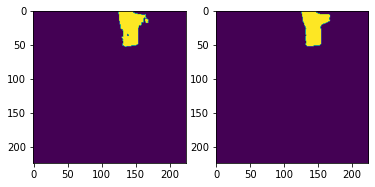

In [ ]:
model = smp.UnetPlusPlus(classes=2,
                encoder_name="se_resnext101_32x4d",
                encoder_weights="imagenet"
               ).to(device)

model2 = smp.UnetPlusPlus(classes=2,
                encoder_name="se_resnext50_32x4d",
                encoder_weights="imagenet",
                in_channels=4
               ).to(device)

model.load_state_dict(torch.load("./best_se_resnext101_32x4d_val_87.14_(81.8).pt")['model_state_dict']) # 경계를 개선하고자 하는 모델 파일 경로
model2.load_state_dict(torch.load("./best_boundry_plus_0.14.pt")['model_state_dict'])  # 경계 개선 네트워크 경로
model = nn.DataParallel(model).to(device) 
model2 = nn.DataParallel(model2).to(device)

img_crop = 64

with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)

        outputs = model(images).mean(axis = 1).unsqueeze(1)
        masks = torch.sigmoid(outputs).cpu().numpy()
        masks = np.squeeze(masks, axis=1)
        masks = (masks > threshold).astype(np.uint8) # Threshold = 0.35

        crop_32_input, crop_32_gt, crop_32_gt_info = [], [], []
        for i, img in enumerate(masks):
            dst = cv2.dilate(img, cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))) # 모폴로지 팽창 연산
            diff_clamped = torch.clamp(torch.Tensor(dst)- torch.Tensor(img), min=0, max=1) # 팽창 - 원본 => 경계
            indices = torch.where(diff_clamped == 1) # [Row, Col]
            xx, yy = torch.clamp(indices[0] - img_crop//2, min=0, max=224-img_crop), torch.clamp(indices[1] - img_crop//2, min=0, max=224-img_crop)

            if xx.shape == torch.Tensor([]).shape: continue
            boundary_mask = [torch.stack([x, y, x+img_crop, y+img_crop]) for x, y in zip(xx, yy)]
            boundary_mask = torch.stack(boundary_mask)
            boundary_mask_output = torchvision.ops.nms(boundary_mask[:, :4].float(), torch.ones(boundary_mask.shape[0]), 0.3)

            for x, y, _, _ in  boundary_mask[boundary_mask_output]:
                crop_32_input.append(torch.cat([images[i, :, x:x+img_crop, y:y+img_crop], torch.Tensor(masks[i, x:x+img_crop, y:y+img_crop].reshape(1, img_crop, img_crop)).to(device)], axis = 0)) # 입력 이미지 차원 [(B+num), 4, 32, 32]
                crop_32_gt_info.append([i,x,y])

        if crop_32_input.__len__() == 0: continue
        crop_32_input = torch.stack(crop_32_input)
        crop_32_input = crop_32_input.to(device)
    
        pred = model2(crop_32_input).mean(1)
        pred_32_mask = torch.sigmoid(pred).cpu().detach().numpy()
        pred_32_mask = (pred_32_mask > threshold).astype(np.uint8)

        plt.subplot(1,2,1)
        plt.imshow(masks[0])

        for (batch_num_idx, idx_x, idx_y), pred_32_mask_one in zip(crop_32_gt_info, pred_32_mask):
            masks[batch_num_idx, idx_x:idx_x+img_crop, idx_y:idx_y+img_crop] = pred_32_mask_one

        plt.subplot(1,2,2)
        plt.imshow(masks[0])
        
        
        for i in range(len(images)):
            mask_rle = rle_encode(masks[i])
            if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                result.append(-1)
            else:
                result.append(mask_rle)

In [ ]:
submit = pd.read_csv('/mnt/ssd1/nyh/AI_Competition/sample_submission.csv')

submit['mask_rle'] = result

In [ ]:
submit.to_csv('./result.csv', index=False)